In [1]:
import numpy as np
import cv2
import time
import os
from matplotlib import pyplot as plt
import mediapipe as mp

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable= False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                              mp_drawing.DrawingSpec(color=(128, 0, 0), thickness=1, circle_radius=1), 
                              mp_drawing.DrawingSpec(color=(192, 192, 192), thickness=1, circle_radius=1))
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [15]:
# Open the webcam
cap = cv2.VideoCapture(0)

# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
    
        # Read the feed
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break
    
        # Make detections 
        image, results = mediapipe_detection(frame, holistic)

        # Draw landmarks
        draw_landmarks(image, results)
        
    
        # Show the frame on the screen
        cv2.imshow("OpenCV Feed", image)
    
        # Check if 'q' key is pressed to exit
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    
    # Release the webcam and close windows
    cap.release()
    cv2.destroyAllWindows()

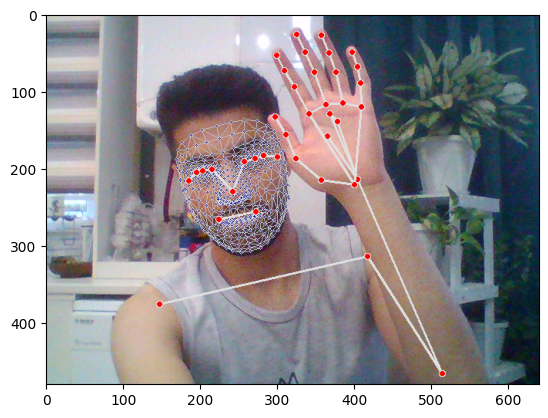

In [9]:
draw_landmarks(frame, results)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [10]:
print(len(results.face_landmarks.landmark))
print(len(results.pose_landmarks.landmark))
print(len(results.left_hand_landmarks.landmark))

468
33
21


In [11]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*3)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    left_hand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    right_hand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, left_hand, right_hand])

In [12]:
print(extract_keypoints(results).shape)
print(33*3 + 468*3 + 21*3 + 21*3)

(1629,)
1629


In [13]:
# Path for extracted data, numpy array
DATA_PATH = os.path.join("MP_data")

# Actions that we try to detect
actions = np.array(["hello", "thanks", "iloveyou"])

# 30 videos worth of data 
num_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

In [14]:
# Create directories

for action in actions:
    for sequence in range(num_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [39]:
# COLLECTING DATASET 

# Open the webcam
cap = cv2.VideoCapture(0)

# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    for action in actions:
        for sequence in range(num_sequences):
            for frame_num in range(sequence_length):

                # Read Feed
                ret, frame = cap.read()

                # Made Detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw Landmarks
                draw_landmarks(image, results)

                # Wait Logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(1000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    
                # Export Keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Show the frame on the screen
                cv2.imshow("OpenCV Feed", image)
            
                # Check if 'q' key is pressed to exit
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

    # Release the webcam and close windows
    cap.release()
    cv2.destroyAllWindows()

In [38]:
    cap.release()
    cv2.destroyAllWindows()